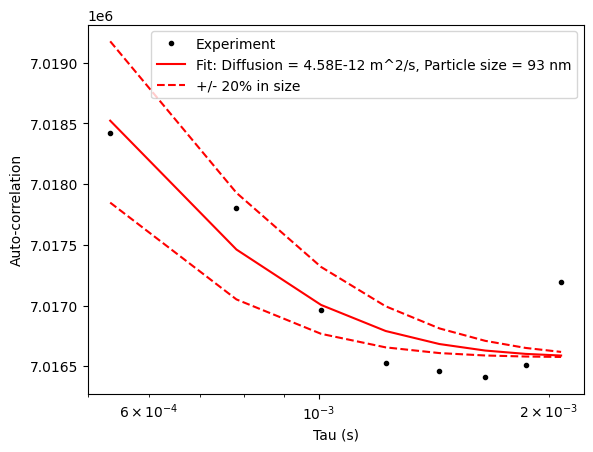

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Constants
lambd = 635e-9          # [m] Laser wavelength
n_s = 1.3325              # Solvent refractive index at wavelength
k = 1.380649e-23        # [J/K] Boltzmann constant
T = 293.15                 # [K] Temperature
eta_s = 0.001          # [Pa.s] Solvent viscosity measurement at T
theta = np.pi / 2       # Scattering angle

# Read data
df = pd.read_csv("data_output_good.csv")
time, y_data = df['Time (seconds)'][0:17], df['DLS Value'][0:17]

# Function to compute autocorrelation
def autocorrelate(series):
    N = len(series)
    s_hat = np.fft.rfft(series)
    return np.fft.irfft(s_hat * np.conj(s_hat), N)

# Ensure N_points is defined dynamically
N_points = len(y_data)

# Scattering vector
q = 4 * np.pi / lambd * n_s * np.sin(theta / 2)

# Time array for autocorrelation
tau = time[:N_points // 2]

# Compute autocorrelation and accumulate it
auto_cum = np.zeros(N_points)
auto = autocorrelate(y_data)  # Compute the autocorrelation
auto_cum += auto  # Update cumulative autocorrelation

# Use only the first half of the autocorrelation data
ydata = auto_cum[:N_points // 2]

# Function to fit
def g(tau, a, b, c):
    return a * np.ones_like(tau) + b * np.exp(-c * tau)

# Initial guess
a0 = ydata[-1]
b0 = ydata[0] - a0
c0 = 2 * q**2 * k * T / (18 * 1e-7 * eta_s)

# Fit the curve
popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])
(a, b, c) = popt

# Extract hydrodynamic radius from fit
D = c / (2 * q**2)                  # Diffusion coefficient
Rh = k * T / (6 * np.pi * D * eta_s) # Hydrodynamic radius
psize = 2 * Rh * 1e9                 # Particle size in nanometers

# Extract error
perr = np.sqrt(np.diag(pcov))
dc_over_c = perr[2] / c
psizeerr = dc_over_c * psize

# Plot results
plt.semilogx(tau, ydata, 'k.', label='Experiment')
plt.semilogx(tau, g(tau, a, b, c), 'r-', label='Fit: Diffusion = %.2E m^2/s, Particle size = %d nm' % (D, psize))
plt.semilogx(tau, g(tau, a, b, 0.83 * c), 'r--', label='+/- 20% in size')
plt.semilogx(tau, g(tau, a, b, 1.25 * c), 'r--')
plt.xlabel('Tau (s)')
plt.ylabel('Auto-correlation')
plt.legend()
plt.show()


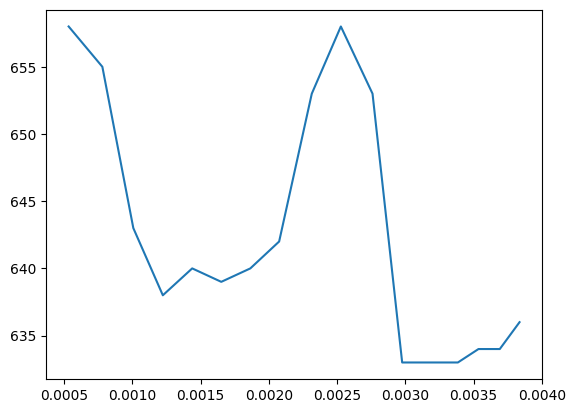

([<matplotlib.lines.Line2D at 0x12c3545d0>], None)

In [5]:
plt.plot(time, y_data), plt.show()

In [9]:
def particle_size(time, y_data):
    # Ensure N_points is defined dynamically
    N_points = len(y_data)

    # Scattering vector
    q = 4 * np.pi / lambd * n_s * np.sin(theta / 2)

    # Time array for autocorrelation
    tau = time[:N_points // 2]

    # Compute autocorrelation and accumulate it
    auto_cum = np.zeros(N_points)
    auto = autocorrelate(y_data)  # Compute the autocorrelation
    auto_cum += auto  # Update cumulative autocorrelation

    # Use only the first half of the autocorrelation data
    ydata = auto_cum[:N_points // 2]

    # Function to fit
    def g(tau, a, b, c):
        return a * np.ones_like(tau) + b * np.exp(-c * tau)

    # Initial guess
    a0 = ydata[-1]
    b0 = ydata[0] - a0
    c0 = 2 * q**2 * k * T / (18 * 1e-7 * eta_s)

    # Fit the curve
    popt, pcov = curve_fit(g, tau, ydata, p0=[a0, b0, c0])
    (a, b, c) = popt

    # Extract hydrodynamic radius from fit
    D = c / (2 * q**2)                  # Diffusion coefficient
    Rh = k * T / (6 * np.pi * D * eta_s) # Hydrodynamic radius
    psize = 2 * Rh * 1e9                 # Particle size in nanometers

    return psize

In [45]:
def psize_per_file(filename):
    df = pd.read_csv(filename)
    time_all, y_data_all = df['Time (seconds)'], df['DLS Value']

    start = 0
    psize = np.empty(len(range(20, len(time_all), 20)))
    for i, end in enumerate(range(20, len(time_all), 20)):
        time, y_data = time_all[start: end], y_data_all[start:end]
        
        try:
            size = particle_size(time, y_data)
            psize[i] = size
            print(f'Size: {size} | Start: {start} | End: {end}')
        except:
            psize[i] = np.nan
            print(f'FAILED | Start: {start} | End: {end}')

        start = end

    iteration = np.array(range(20, len(time_all), 20), dtype=float)
    iteration[psize == np.nan] = np.nan

    return iteration, psize

In [49]:
file_vs_size = {}
all_files = ['data_output_good.csv', 'data_output_run2.csv', 'data_output_run3.csv', 'data_output_run4.csv', 'data_output_run5.csv']
for filename in all_files:
    print(f'FILENAME: {filename}')
    iteration, psize = psize_per_file(filename)
    file_vs_size[filename] = [iteration, psize]

    print('')

FILENAME: data_output_good.csv
Size: 87.84768490021747 | Start: 0 | End: 20
FAILED | Start: 20 | End: 40
Size: 190.98593171027437 | Start: 40 | End: 60
Size: 190.98593171027437 | Start: 60 | End: 80
Size: 190.98593171027437 | Start: 80 | End: 100
Size: 190.98593171027437 | Start: 100 | End: 120
Size: 190.98593171027437 | Start: 120 | End: 140
Size: 190.98593171027437 | Start: 140 | End: 160
Size: 190.98593171027437 | Start: 160 | End: 180
Size: 190.98593171027437 | Start: 180 | End: 200
Size: 190.98593171027437 | Start: 200 | End: 220
Size: 190.98593171027437 | Start: 220 | End: 240
Size: 190.98593171027437 | Start: 240 | End: 260
Size: 190.98593171027437 | Start: 260 | End: 280
Size: 190.98593171027437 | Start: 280 | End: 300
Size: 190.98593171027437 | Start: 300 | End: 320
Size: 190.98593171027437 | Start: 320 | End: 340
Size: 190.98593171027437 | Start: 340 | End: 360
Size: 190.98593171027437 | Start: 360 | End: 380
Size: 190.98593171027437 | Start: 380 | End: 400
Size: 190.98593171

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Size: 190.98593171027437 | Start: 740 | End: 760
Size: 190.98593171027437 | Start: 760 | End: 780
Size: 190.98593171027437 | Start: 780 | End: 800
Size: 190.98593171027437 | Start: 800 | End: 820
Size: 190.98593171027437 | Start: 820 | End: 840
Size: 190.98593171027437 | Start: 840 | End: 860
Size: 190.98593171027437 | Start: 860 | End: 880
Size: 190.98593171027437 | Start: 880 | End: 900
Size: 190.98593171027437 | Start: 900 | End: 920
Size: 190.98593171027437 | Start: 920 | End: 940
Size: 190.98593171027437 | Start: 940 | End: 960
Size: 190.98593171027437 | Start: 960 | End: 980
Size: 190.98593171027437 | Start: 980 | End: 1000
Size: 190.98593171027437 | Start: 1000 | End: 1020
Size: 190.98593171027437 | Start: 1020 | End: 1040
Size: 190.98593171027437 | Start: 1040 | End: 1060
Size: 190.98593171027437 | Start: 1060 | End: 1080
Size: 190.98593171027437 | Start: 1080 | End: 1100
Size: 190.98593171027437 | Start: 1100 | End: 1120
Size: 190.98593171027437 | Start: 1120 | End: 1140
Size:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


FAILED | Start: 0 | End: 20
Size: 0.38565947429238656 | Start: 20 | End: 40
Size: 190.98593171027437 | Start: 40 | End: 60
Size: 190.98593171027437 | Start: 60 | End: 80
Size: 190.98593171027437 | Start: 80 | End: 100
Size: 190.98593171027437 | Start: 100 | End: 120
Size: 190.98593171027437 | Start: 120 | End: 140
Size: 190.98593171027437 | Start: 140 | End: 160
Size: 190.98593171027437 | Start: 160 | End: 180
Size: 190.98593171027437 | Start: 180 | End: 200
Size: 190.98593171027437 | Start: 200 | End: 220
Size: 190.98593171027437 | Start: 220 | End: 240
Size: 190.98593171027437 | Start: 240 | End: 260
Size: 190.98593171027437 | Start: 260 | End: 280
Size: 190.98593171027437 | Start: 280 | End: 300

FILENAME: data_output_run5.csv


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Size: 15.847242559581566 | Start: 0 | End: 20
Size: 0.27652626508812633 | Start: 20 | End: 40
Size: 190.98593171027437 | Start: 40 | End: 60
Size: 190.98593171027437 | Start: 60 | End: 80
Size: 190.98593171027437 | Start: 80 | End: 100
Size: 190.98593171027437 | Start: 100 | End: 120
Size: 190.98593171027437 | Start: 120 | End: 140
Size: 190.98593171027437 | Start: 140 | End: 160
Size: 190.98593171027437 | Start: 160 | End: 180
Size: 190.98593171027437 | Start: 180 | End: 200
Size: 190.98593171027437 | Start: 200 | End: 220
Size: 190.98593171027437 | Start: 220 | End: 240
Size: 190.98593171027437 | Start: 240 | End: 260
Size: 190.98593171027437 | Start: 260 | End: 280
Size: 190.98593171027437 | Start: 280 | End: 300



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


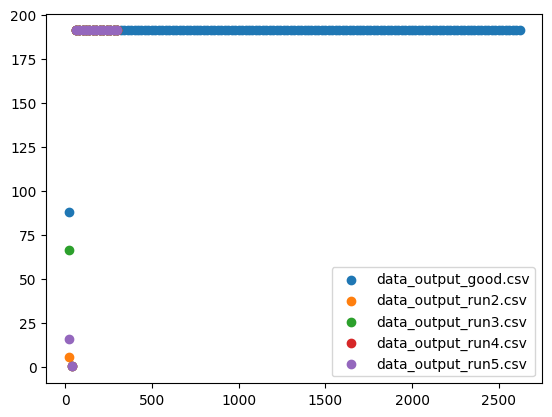

In [51]:
for key, value in file_vs_size.items():
    plt.scatter(value[0], value[1], label=key)

plt.legend()
plt.show()

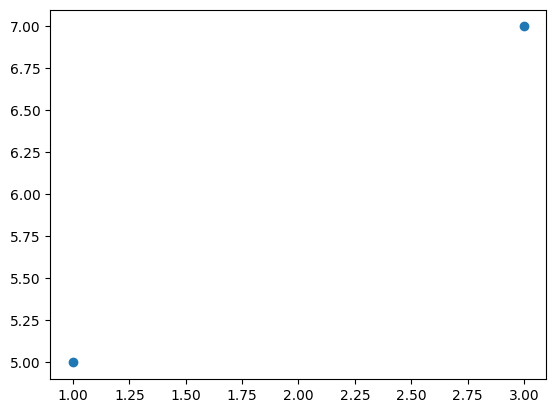

In [19]:
x = np.array([1, np.nan, 3])
y = np.array([5, 6, 7])
plt.scatter(x, y)